# Analyze models
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh
##### date: March 20, 2022


## Python stuff

In [1]:
import sys, imp, os, copy

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp

import scipy.stats as stats
import seaborn as sns

import experiment_settings
import file_methods, plots, data_processing

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  
print(f"tensorflow-probability version = {tfp.__version__}")  

python version = 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]
numpy version = 1.22.2
xarray version = 2022.3.0
tensorflow version = 2.7.0
tensorflow-probability version = 0.15.0


## User Choices

In [3]:
EXP_NAME = 'exp15C_126_uniform'#'exp15C_370_uniform' #'exp15C_126_uniform'#'exp20C_126'#'exp15C_126_uniform' #'exp20C_126_force'
#-------------------------------------------------------

settings = experiment_settings.get_settings(EXP_NAME)
# display(settings)

MODEL_DIRECTORY = 'saved_models/'        
PREDICTIONS_DIRECTORY = 'saved_predictions/'
DATA_DIRECTORY = 'data/'
DIAGNOSTICS_DIRECTORY = 'model_diagnostics/'
FIGURE_DIRECTORY = 'figures/'

## Get seed to show in plot
You need to first run compare_random_seeds.ipynb to ensure the data/stats on your experiments were saved in the df_random_seed.pickle file.

In [4]:
df_metrics = pd.read_pickle(PREDICTIONS_DIRECTORY + "df_random_seed.pickle")
df = df_metrics[df_metrics["exp_name"]==EXP_NAME]
PLOT_SEED = df_metrics.iloc[df['loss_val'].idxmin()]["seed"]
print(PLOT_SEED)
display(df)

9156


,exp_name,seed,hiddens,ridge_param,error_val,error_test,loss_val,loss_test,d_val,d_test,d_valtest,best_2021_mu,best_2021_sigma,giss_2021_mu,giss_2021_sigma
242,exp15C_126_uniform,1257,"[25, 25]",10.0,6.205996,6.428802,3.410503,3.492395,0.017804,0.025901,0.016335,12.031135,9.819970,12.463233,10.649299
262,exp15C_126_uniform,5322,"[25, 25]",10.0,5.976015,6.471847,3.440346,3.591122,0.020548,0.034385,0.023787,13.144685,8.793914,12.662911,9.751287
263,exp15C_126_uniform,2247,"[25, 25]",10.0,5.957422,6.241846,3.441067,3.386027,0.019522,0.023708,0.018584,13.708028,9.031709,12.661008,9.636039
264,exp15C_126_uniform,5757,"[25, 25]",10.0,6.759937,6.194938,3.515777,3.498796,0.020899,0.043392,0.019458,12.678473,8.399349,12.545131,8.644230
265,exp15C_126_uniform,1170,"[25, 25]",10.0,5.790084,5.952929,3.449462,3.333022,0.020915,0.020421,0.018209,9.485677,9.114793,10.930625,9.275677
266,exp15C_126_uniform,9156,"[25, 25]",10.0,5.750686,6.598439,3.387198,3.761889,0.021660,0.058292,0.032807,14.194879,7.902994,13.022483,8.375112
267,exp15C_126_uniform,6613,"[25, 25]",10.0,6.739580,6.891872,3.516804,3.667965,0.024625,0.047400,0.023015,14.548087,8.387967,14.028255,8.626917
268,exp15C_126_uniform,9983,"[25, 25]",10.0,6.519293,5.473722,3.493200,3.366171,0.022739,0.025191,0.016897,13.079854,7.879709,13.027745,8.334323
269,exp15C_126_uniform,4348,"[25, 25]",10.0,7.230375,6.526332,3.618889,3.516303,0.021764,0.022474,0.021018,15.440419,9.519608,14.858743,9.969481
270,exp15C_126_uniform,5869,"[25, 25]",10.0,6.530377,6.528548,3.638910,3.587199,0.032016,0.026978,0.028124,14.701825,10.438483,14.617084,11.834300


## Plotting Functions

In [5]:
FS = 10

### for white background...
# plt.rc('text',usetex=True)
plt.rc('text',usetex=False)
# plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

In [6]:
model_name_plot = EXP_NAME + '_' + str(PLOT_SEED)

In [7]:
imp.reload(file_methods)
imp.reload(data_processing)

rng = np.random.default_rng(settings["rng_seed"])
settings["seed"] = PLOT_SEED

# get model name
model_name = file_methods.get_model_name(settings)

# load the model
model = file_methods.load_tf_model(model_name, MODEL_DIRECTORY)

settings_new = settings
settings_new["gcmsub"] = "MIROC"
settings_new["n_train_val_test"] = (10, 0, 0)
# get the data
(x_train, 
 x_val, 
 x_test, 
 y_train, 
 y_val, 
 y_test, 
 onehot_train, 
 onehot_val, 
 onehot_test, 
 y_yrs_train, 
 y_yrs_val, 
 y_yrs_test, 
 target_years, 
 map_shape,
 settings) = data_processing.get_cmip_data(DATA_DIRECTORY, settings)   

       

[3 7 8 9 5 2 0 1 6 4] [] []
tas_Amon_historical_ssp126_MIROC6_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2060
tas_Amon_historical_ssp126_MIROC-ES2L_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2034
---------------------------
data_train.shape = (20, 131, 72, 144)
data_val.shape = (0, 131, 72, 144)
data_test.shape = (0, 131, 72, 144)
(2620, 10368) (2620,) (2620,)
(0, 10368) (0,) (0,)
(0, 10368) (0,) (0,)


tas_Amon_historical_ssp126_MIROC6_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2060
tas_Amon_historical_ssp126_MIROC-ES2L_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2034


2022-04-09 20:09:24.770166: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


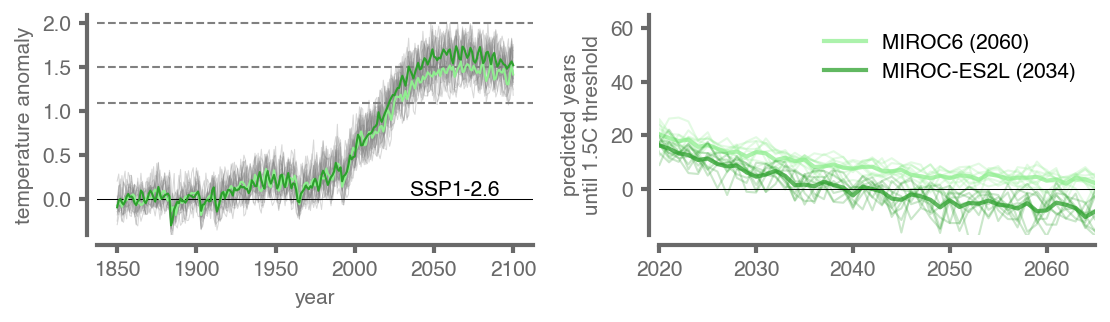

In [8]:
filenames = file_methods.get_cmip_filenames(settings_new, verbose=0)
N_GCMS = len(filenames)

# loop through the models and plot
clr = ('#90EE90','tab:green')
fig,axs = plt.subplots(1,2,figsize=(3*2.5,2.25))

if target_years[0]==2100:
    label1 ='MIROC6'
    label2 = 'MIROC-ES2L'
else:
    label1 = 'MIROC6 (' + str(int(target_years[0])) + ')'
    label2 = 'MIROC-ES2L (' + str(int(target_years[1])) + ')'


#---------------------------------------------
plt.subplot(1,2,1)
for imodel, f in enumerate(filenames):
    print(f)
    da = file_methods.get_netcdf_da(DATA_DIRECTORY + f)
    f_labels, f_years, f_target_year = data_processing.get_labels(da, settings_new,)

    # compute global mean
    global_mean = data_processing.compute_global_mean(da)
    baseline_mean = global_mean.sel(time=slice(str(settings["baseline_yr_bounds"][0]),str(settings["baseline_yr_bounds"][1]))).mean('time')
    global_mean_anomalies = global_mean - baseline_mean
    
    # plot the members
    plt.plot(f_years, 
             np.swapaxes(global_mean_anomalies.to_numpy(),1,0), 
             color='gray',
             linewidth=.5,
             alpha=.3,
             zorder=1,
            )
    # plot ensemble mean
    plt.plot(f_years, 
             np.mean(global_mean_anomalies,axis=0), 
             color=clr[imodel],
             linewidth=1.,
             alpha=1.,
             zorder=4,
            )
    
# plt.title('Global Mean Temperatures for SSP'+ str(settings["ssp"]),fontsize=12)
plt.xlabel('year',fontsize=FS)
plt.ylabel('temperature anomaly',fontsize=FS)
plt.xticks(np.arange(1850,2150,50),np.arange(1850,2150,50))

plt.ylim(-.4,2.1)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axhline(y=1.1, color='gray', linewidth=1.0, linestyle='--')
plt.axhline(y=1.5, color='gray', linewidth=1.0, linestyle='--')
plt.axhline(y=2.0, color='gray', linewidth=1.0, linestyle='--')

plt.text(2035,
         0,
         "SSP" + settings["ssp"][0] + '-' + settings["ssp"][1] + '.' + settings["ssp"][-1],
         fontsize=FS,
         horizontalalignment="left",
         verticalalignment="bottom",
         color='k', 
         weight="bold",
        )

format_spines(plt.gca())


#--------------------------------------
plt.subplot(1,2,2)
# plot the predictions for 8 members
YEARS_UNIQUE = np.unique(y_yrs_train)

miroc_pred = model.predict(x_train)
mu_pred = miroc_pred[:,0].reshape(2,10,len(YEARS_UNIQUE))
sigma_pred = miroc_pred[:,1].reshape(2,10,len(YEARS_UNIQUE))

plt.plot(YEARS_UNIQUE,mu_pred[0,:,:].swapaxes(1,0),color=clr[0],linewidth=1.,alpha=.25)
plt.plot(YEARS_UNIQUE,np.mean(mu_pred[0,:,:].swapaxes(1,0),axis=1),
         color=clr[0],
         linewidth=2.,
         alpha=.75,
         label=label1,
        )

plt.plot(YEARS_UNIQUE,mu_pred[1,:,:].swapaxes(1,0),color=clr[1],linewidth=1.,alpha=.25)
plt.plot(YEARS_UNIQUE,np.mean(mu_pred[1,:,:].swapaxes(1,0),axis=1),
         color=clr[1],
         linewidth=2.,
         alpha=.75,
         label=label2,
        )
plt.legend(frameon=False)    
# plt.ylim(-17,30)    
plt.ylim(-17,65)    
plt.xlim(2020,2065)
ax = plt.gca()
format_spines(ax)
plt.ylabel('predicted years\nuntil ' + str(settings["target_temp"]) + 'C threshold')
# plt.title(model_name_plot)

plt.axhline(y=0, color='black', linewidth=0.5)

plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + model_name_plot + '_miroc_inference', dpi=savefig_dpi)
plt.show()    
    

In [9]:
# filenames = file_methods.get_cmip_filenames(settings_new, verbose=0)
# N_GCMS = len(filenames)

# # loop through the models and plot
# clr = ('navy','fuchsia')
# fig,axs = plt.subplots(1,2,figsize=(3*2.5,2.25))

# if target_years[0]==2100:
#     # label1 ='MIROC6'
#     label1 = 'MIROC-ES2L'
# else:
#     # label1 = 'MIROC6 (' + str(int(target_years[0])) + ')'
#     label1 = 'MIROC-ES2L (' + str(int(target_years[0])) + ')'


# #---------------------------------------------
# plt.subplot(1,2,1)
# for imodel, f in enumerate(filenames):
#     print(f)
#     da = file_methods.get_netcdf_da(DATA_DIRECTORY + f)
#     f_labels, f_years, f_target_year = data_processing.get_labels(da, settings_new,)

#     # compute global mean
#     global_mean = data_processing.compute_global_mean(da)
#     baseline_mean = global_mean.sel(time=slice(str(settings["baseline_yr_bounds"][0]),str(settings["baseline_yr_bounds"][1]))).mean('time')
#     global_mean_anomalies = global_mean - baseline_mean
    
#     # plot the members
#     plt.plot(f_years, 
#              np.swapaxes(global_mean_anomalies.to_numpy(),1,0), 
#              color='gray',
#              linewidth=.5,
#              alpha=.3,
#             )
#     # plot ensemble mean
#     plt.plot(f_years, 
#              np.mean(global_mean_anomalies,axis=0), 
#              color=clr[imodel],
#              linewidth=1.,
#              alpha=1.,
#             )
    
# # plt.title('Global Mean Temperatures for SSP'+ str(settings["ssp"]),fontsize=12)
# plt.xlabel('year',fontsize=FS)
# plt.ylabel('temperature anomaly',fontsize=FS)
# plt.xticks(np.arange(1850,2150,50),np.arange(1850,2150,50))

# plt.ylim(-.4,2.1)
# plt.axhline(y=0, color='black', linewidth=0.5)
# plt.axhline(y=1.1, color='gray', linewidth=1.0, linestyle='--')
# plt.axhline(y=1.5, color='gray', linewidth=1.0, linestyle='--')
# plt.axhline(y=2.0, color='gray', linewidth=1.0, linestyle='--')

# plt.text(2035,
#          0,
#          "SSP" + settings["ssp"][0] + '-' + settings["ssp"][1] + '.' + settings["ssp"][-1],
#          fontsize=FS,
#          horizontalalignment="left",
#          verticalalignment="bottom",
#          color='k', 
#          weight="bold",
#         )

# format_spines(plt.gca())


# #--------------------------------------
# plt.subplot(1,2,2)
# # plot the predictions for 8 members
# YEARS_UNIQUE = np.unique(y_yrs_train)

# miroc_pred = model.predict(x_train)
# mu_pred = miroc_pred[:,0].reshape(1,10,len(YEARS_UNIQUE))
# sigma_pred = miroc_pred[:,1].reshape(1,10,len(YEARS_UNIQUE))

# plt.plot(YEARS_UNIQUE,mu_pred[0,:,:].swapaxes(1,0),color=clr[0],linewidth=1.,alpha=.25)
# plt.plot(YEARS_UNIQUE,np.mean(mu_pred[0,:,:].swapaxes(1,0),axis=1),
#          color=clr[0],
#          linewidth=2.,
#          alpha=.75,
#          label=label1,
#         )

# plt.legend(frameon=False)    
# # plt.ylim(-17,30)    
# plt.ylim(-17,65)    
# plt.xlim(2020,2065)
# ax = plt.gca()
# format_spines(ax)
# plt.ylabel('predicted years\nuntil ' + str(settings["target_temp"]) + 'C threshold')
# # plt.title(model_name_plot)

# plt.axhline(y=0, color='black', linewidth=0.5)

# plt.tight_layout()
# plots.savefig(FIGURE_DIRECTORY + model_name_plot + '_miroc_inference', dpi=savefig_dpi)
# plt.show()    
    



In [10]:
year_plot = 2021
i = np.where(YEARS_UNIQUE==year_plot)[0]
YEARS_UNIQUE[i]

array([2021])

In [11]:
np.mean(mu_pred[:,:,i],axis=1)+year_plot

array([[2039.9733],
       [2036.0371]], dtype=float32)

#### 